# **ViT Transformers**

In [ ]:
pip install torch torchvision transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/insuldataset'
import os
PATH = os.path.join(os.path.dirname(root_path), "insuldataset")
print(PATH)

/content/drive/MyDrive/insuldataset


In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ViT
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load dataset
#dataset_dir = '/content/drive/MyDrive/insuldataset'  # Update this path
train_dataset = ImageFolder(os.path.join(PATH, 'Train'), transform=transform)
test_dataset = ImageFolder(os.path.join(PATH, 'Test'), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# **Vision Transformer with Adadelta Optimizers**

In [ ]:
from transformers import ViTForImageClassification

# Load the pre-trained Vision Transformer model
num_classes = len(train_dataset.classes)  # Number of classes in your dataset
vtadadeltamodel = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vtadadeltamodel.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
import torch.nn as nn
from torch.optim import Adadelta
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adadelta(vtadadeltamodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
vtadadeltamodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vtadadeltamodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 49/49 [15:56<00:00, 19.53s/it]


Epoch [1/10], Loss: 0.6999


100%|██████████| 49/49 [04:13<00:00,  5.17s/it]


Epoch [2/10], Loss: 0.6956


100%|██████████| 49/49 [03:34<00:00,  4.37s/it]


Epoch [3/10], Loss: 0.6908


100%|██████████| 49/49 [03:32<00:00,  4.34s/it]


Epoch [4/10], Loss: 0.6860


100%|██████████| 49/49 [03:30<00:00,  4.29s/it]


Epoch [5/10], Loss: 0.6813


100%|██████████| 49/49 [03:31<00:00,  4.31s/it]


Epoch [6/10], Loss: 0.6767


100%|██████████| 49/49 [03:31<00:00,  4.31s/it]


Epoch [7/10], Loss: 0.6725


100%|██████████| 49/49 [03:32<00:00,  4.33s/it]


Epoch [8/10], Loss: 0.6681


100%|██████████| 49/49 [03:31<00:00,  4.32s/it]


Epoch [9/10], Loss: 0.6638


100%|██████████| 49/49 [03:40<00:00,  4.51s/it]

Epoch [10/10], Loss: 0.6595


Accuracy on the test dataset: 0.79


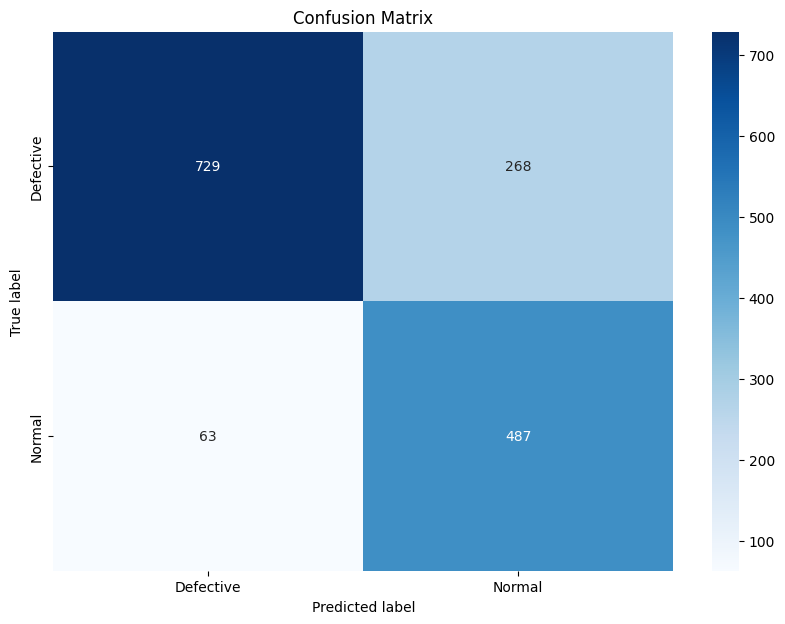

Accuracy 0.7860374919198448
Precision 0.6450331125827815
Recall (Sensitivity) 0.8854545454545455
F1 Score 0.746360153256705
mAP 0.61187148340557


In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score
# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtadadeltamodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtadadeltamodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)



In [ ]:
vtadadeltamodel.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtadadeltamodel(images).logits
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 70.22%


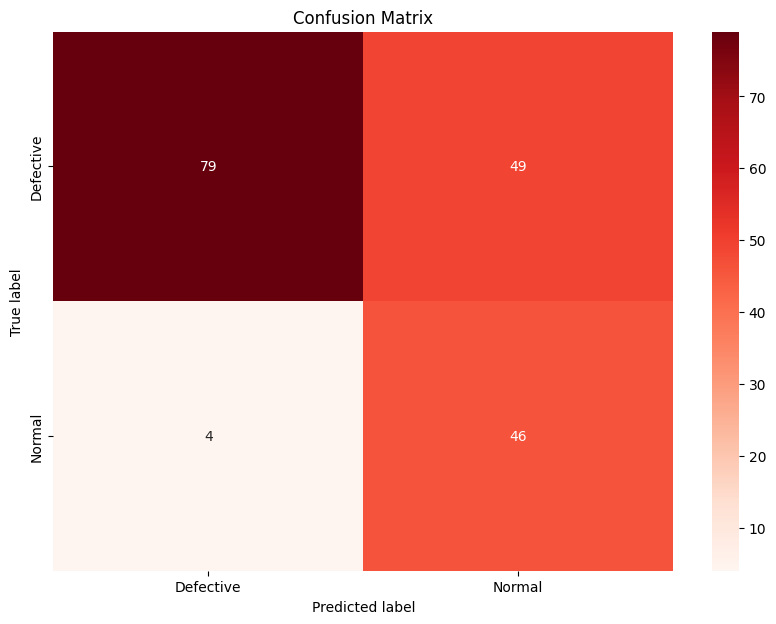

Accuracy 0.702247191011236
Precision 0.4842105263157895
Recall (Sensitivity) 0.92
F1 Score 0.6344827586206897
mAP 0.4679455943228859


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtadadeltamodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtadadeltamodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

Accuracy on the test dataset: 0.79


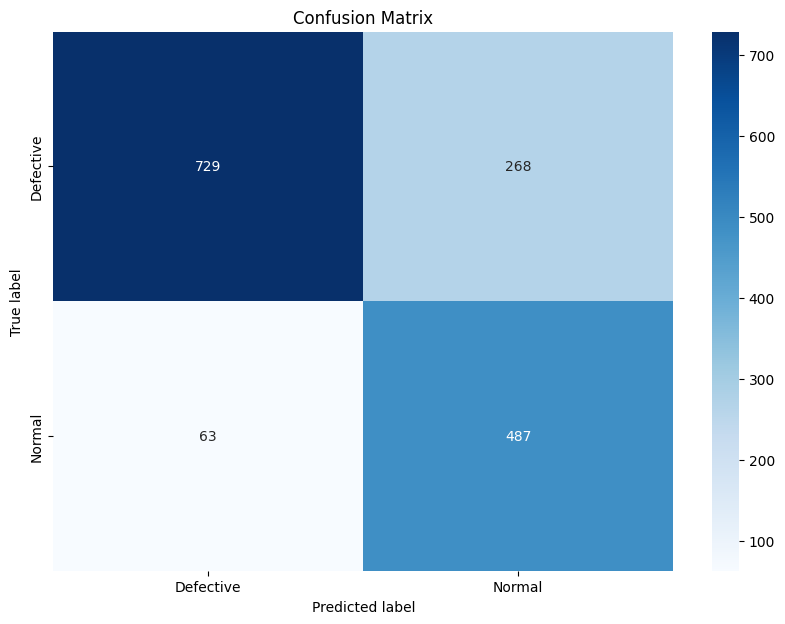

Accuracy 0.7860374919198448
Precision 0.6450331125827815
Recall (Sensitivity) 0.8854545454545455
F1 Score 0.746360153256705
mAP 0.61187148340557


In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score
# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtadadeltamodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtadadeltamodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)



# **SGD optimizer for vision transformers**

In [ ]:
from transformers import ViTForImageClassification

# Load the pre-trained Vision Transformer model
num_classes = len(train_dataset.classes)  # Number of classes in your dataset
vtsdgmodel = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vtsdgmodel.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = SGD(vtsdgmodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
vtsdgmodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vtsdgmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 49/49 [03:29<00:00,  4.27s/it]


Epoch [1/10], Loss: 0.7129


100%|██████████| 49/49 [03:29<00:00,  4.28s/it]


Epoch [2/10], Loss: 0.6965


100%|██████████| 49/49 [03:30<00:00,  4.30s/it]


Epoch [3/10], Loss: 0.6808


100%|██████████| 49/49 [03:29<00:00,  4.27s/it]


Epoch [4/10], Loss: 0.6655


100%|██████████| 49/49 [03:28<00:00,  4.26s/it]


Epoch [5/10], Loss: 0.6521


100%|██████████| 49/49 [03:28<00:00,  4.26s/it]


Epoch [6/10], Loss: 0.6380


100%|██████████| 49/49 [03:29<00:00,  4.28s/it]


Epoch [7/10], Loss: 0.6252


100%|██████████| 49/49 [03:30<00:00,  4.31s/it]


Epoch [8/10], Loss: 0.6117


100%|██████████| 49/49 [03:29<00:00,  4.27s/it]


Epoch [9/10], Loss: 0.5991


100%|██████████| 49/49 [03:30<00:00,  4.30s/it]

Epoch [10/10], Loss: 0.5871


Accuracy on the test dataset: 0.74


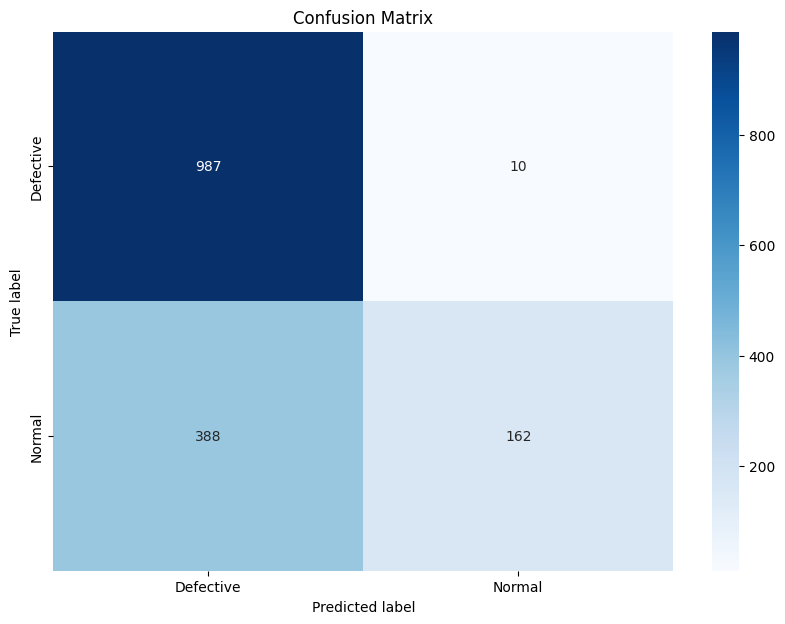

Accuracy 0.7427278603749192
Precision 0.9418604651162791
Recall (Sensitivity) 0.29454545454545455
F1 Score 0.4487534626038781
mAP 0.5282287343299655


In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score
# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtsdgmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtsdgmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)



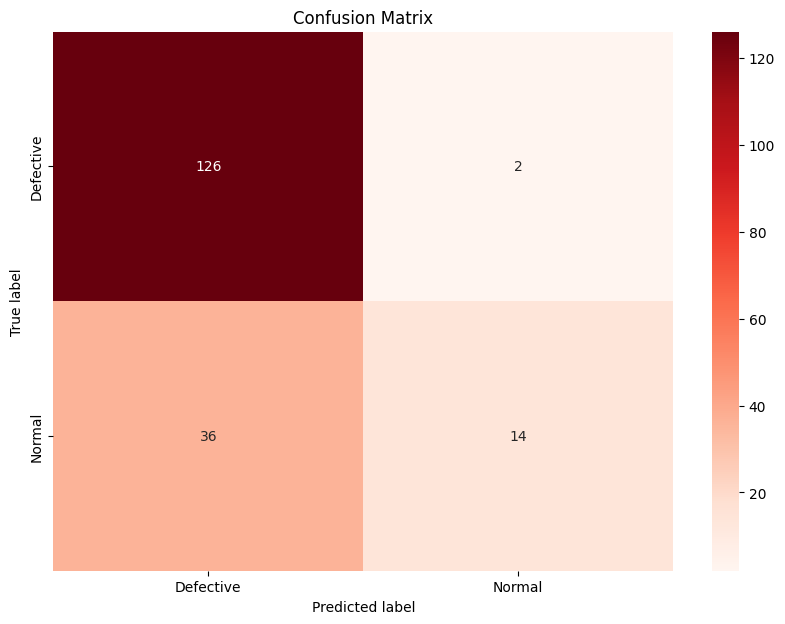

Accuracy 0.7865168539325843
Precision 0.875
Recall (Sensitivity) 0.28
F1 Score 0.42424242424242425
mAP 0.447247191011236


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtsdgmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtsdgmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

# **AdaGrad Optimizer for Vision Transformers**

In [ ]:
from transformers import ViTForImageClassification

# Load the pre-trained Vision Transformer model
num_classes = len(train_dataset.classes)  # Number of classes in your dataset
vtadagradmodel = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vtadagradmodel.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
import torch.nn as nn
from torch.optim import Adagrad
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adagrad(vtadagradmodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
vtadagradmodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vtadagradmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 49/49 [03:30<00:00,  4.29s/it]


Epoch [1/10], Loss: 0.1079


100%|██████████| 49/49 [03:32<00:00,  4.34s/it]


Epoch [2/10], Loss: 0.0137


100%|██████████| 49/49 [03:32<00:00,  4.33s/it]


Epoch [3/10], Loss: 0.0097


100%|██████████| 49/49 [03:29<00:00,  4.28s/it]


Epoch [4/10], Loss: 0.0079


100%|██████████| 49/49 [03:33<00:00,  4.35s/it]


Epoch [5/10], Loss: 0.0068


100%|██████████| 49/49 [03:32<00:00,  4.34s/it]


Epoch [6/10], Loss: 0.0060


100%|██████████| 49/49 [03:31<00:00,  4.31s/it]


Epoch [7/10], Loss: 0.0055


100%|██████████| 49/49 [03:33<00:00,  4.36s/it]


Epoch [8/10], Loss: 0.0050


100%|██████████| 49/49 [03:31<00:00,  4.32s/it]


Epoch [9/10], Loss: 0.0046


100%|██████████| 49/49 [03:32<00:00,  4.34s/it]

Epoch [10/10], Loss: 0.0043


Accuracy on the test dataset: 1.00


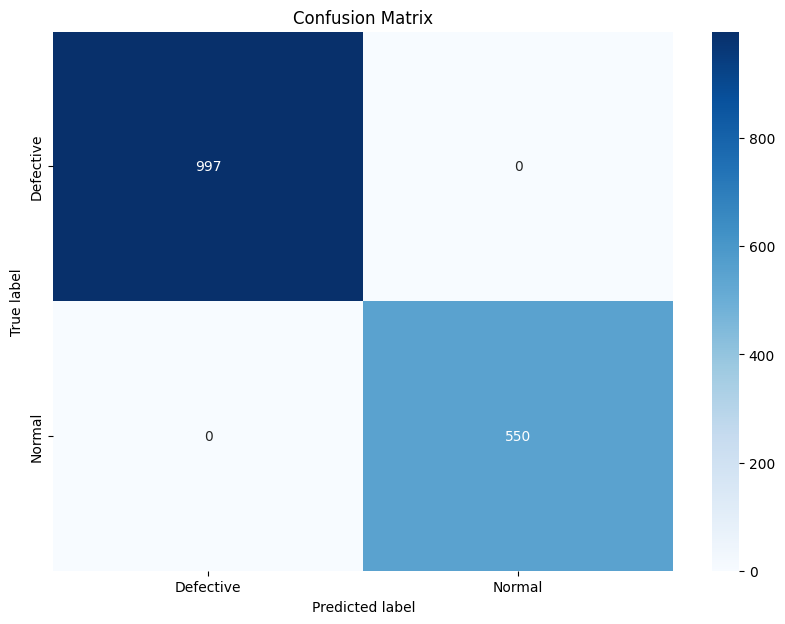

Accuracy 1.0
Precision 1.0
Recall (Sensitivity) 1.0
F1 Score 1.0
mAP 1.0


In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score
# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtadagradmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtadagradmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)



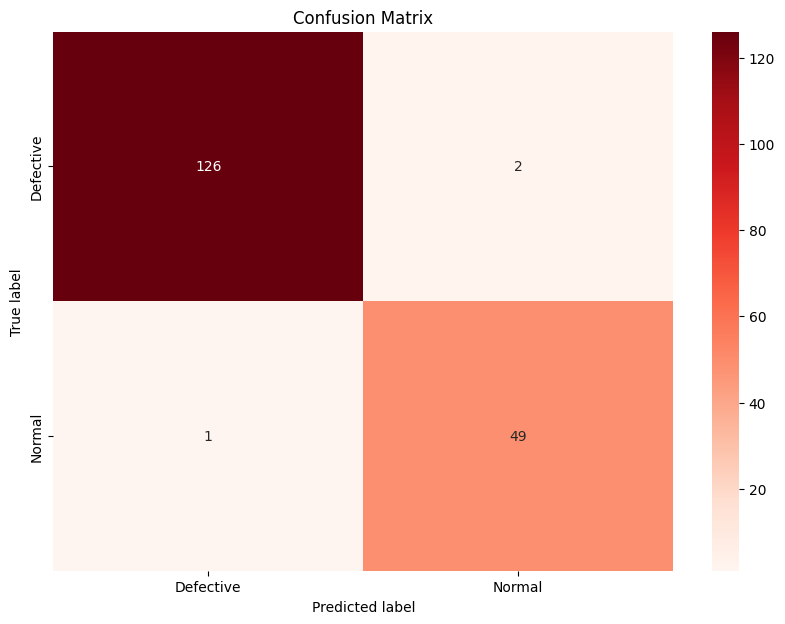

Accuracy 0.9831460674157303
Precision 0.9607843137254902
Recall (Sensitivity) 0.98
F1 Score 0.9702970297029703
mAP 0.9471866049790703


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtadagradmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtadagradmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

# **RMSProp Optimier for Vision Transformers**

In [ ]:
from transformers import ViTForImageClassification

# Load the pre-trained Vision Transformer model
num_classes = len(train_dataset.classes)  # Number of classes in your dataset
vtrmsmodel = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vtrmsmodel.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
import torch.nn as nn
from torch.optim import RMSprop
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = RMSprop(vtrmsmodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
vtrmsmodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vtrmsmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 41/41 [08:49<00:00, 12.91s/it]


Epoch [1/10], Loss: 0.7105


100%|██████████| 41/41 [02:55<00:00,  4.29s/it]


Epoch [2/10], Loss: 0.6780


100%|██████████| 41/41 [02:52<00:00,  4.20s/it]


Epoch [3/10], Loss: 0.6408


100%|██████████| 41/41 [02:54<00:00,  4.26s/it]


Epoch [4/10], Loss: 0.5821


100%|██████████| 41/41 [02:55<00:00,  4.27s/it]


Epoch [5/10], Loss: 0.3848


100%|██████████| 41/41 [02:54<00:00,  4.25s/it]


Epoch [6/10], Loss: 0.2048


100%|██████████| 41/41 [02:56<00:00,  4.31s/it]


Epoch [7/10], Loss: 0.1250


100%|██████████| 41/41 [02:56<00:00,  4.30s/it]


Epoch [8/10], Loss: 0.0552


100%|██████████| 41/41 [02:55<00:00,  4.28s/it]


Epoch [9/10], Loss: 0.0223


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]

Epoch [10/10], Loss: 0.1284


Accuracy on the test dataset: 1.00


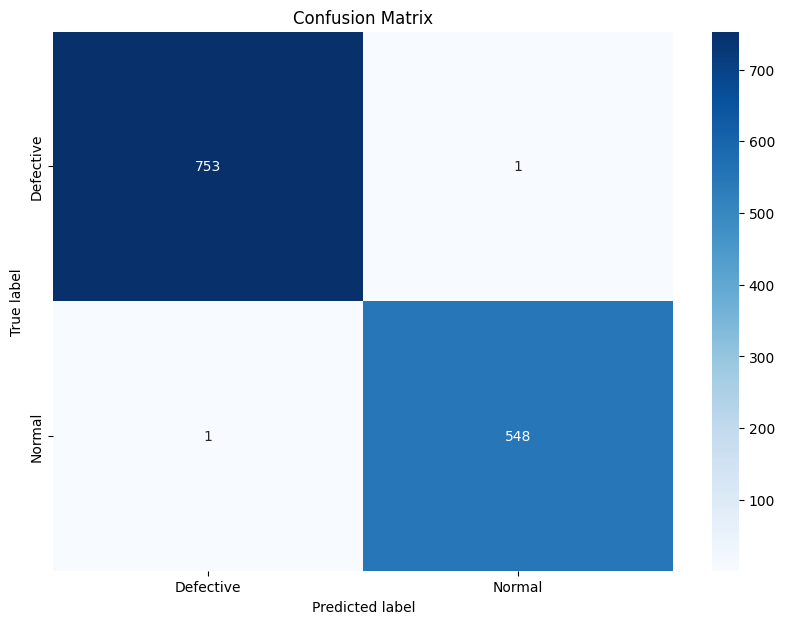

Accuracy 0.9984650805832693
Precision 0.9981785063752276
Recall (Sensitivity) 0.9981785063752276
F1 Score 0.9981785063752276
mAP 0.9971277902978457


In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score
# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtrmsmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtrmsmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)



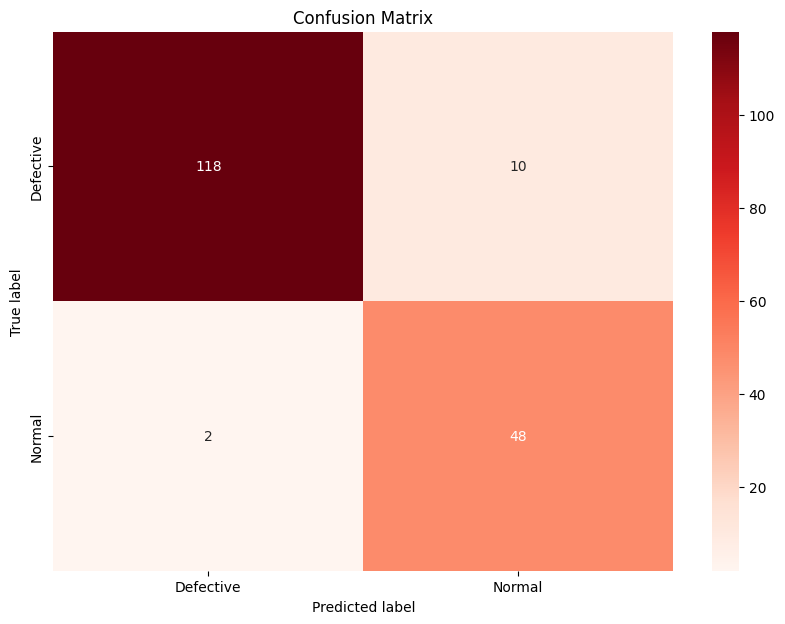

Accuracy 0.9325842696629213
Precision 0.8275862068965517
Recall (Sensitivity) 0.96
F1 Score 0.8888888888888888
mAP 0.8057187136768694


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtrmsmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtrmsmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

# **Adam Optimizer for Vision Transformers**

In [ ]:
from transformers import ViTForImageClassification

# Load the pre-trained Vision Transformer model
num_classes = len(train_dataset.classes)  # Number of classes in your dataset
vtadammodel = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vtadammodel.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vtadammodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
vtadammodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vtadammodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 41/41 [02:55<00:00,  4.29s/it]


Epoch [1/10], Loss: 0.1259


100%|██████████| 41/41 [02:57<00:00,  4.34s/it]


Epoch [2/10], Loss: 0.0135


100%|██████████| 41/41 [02:59<00:00,  4.37s/it]


Epoch [3/10], Loss: 0.0033


100%|██████████| 41/41 [02:58<00:00,  4.36s/it]


Epoch [4/10], Loss: 0.0017


100%|██████████| 41/41 [02:57<00:00,  4.32s/it]


Epoch [5/10], Loss: 0.0012


100%|██████████| 41/41 [02:57<00:00,  4.32s/it]


Epoch [6/10], Loss: 0.0009


100%|██████████| 41/41 [02:58<00:00,  4.35s/it]


Epoch [7/10], Loss: 0.0007


100%|██████████| 41/41 [02:56<00:00,  4.30s/it]


Epoch [8/10], Loss: 0.0006


100%|██████████| 41/41 [02:57<00:00,  4.33s/it]


Epoch [9/10], Loss: 0.0005


100%|██████████| 41/41 [02:57<00:00,  4.33s/it]

Epoch [10/10], Loss: 0.0004


Accuracy on the test dataset: 1.00


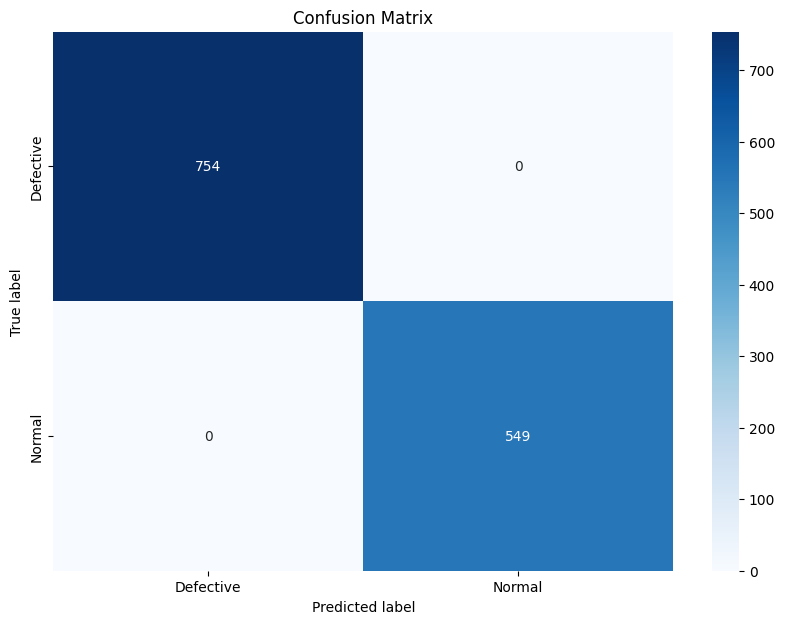

Accuracy 1.0
Precision 1.0
Recall (Sensitivity) 1.0
F1 Score 1.0
mAP 1.0


In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score
# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtadammodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtadammodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)



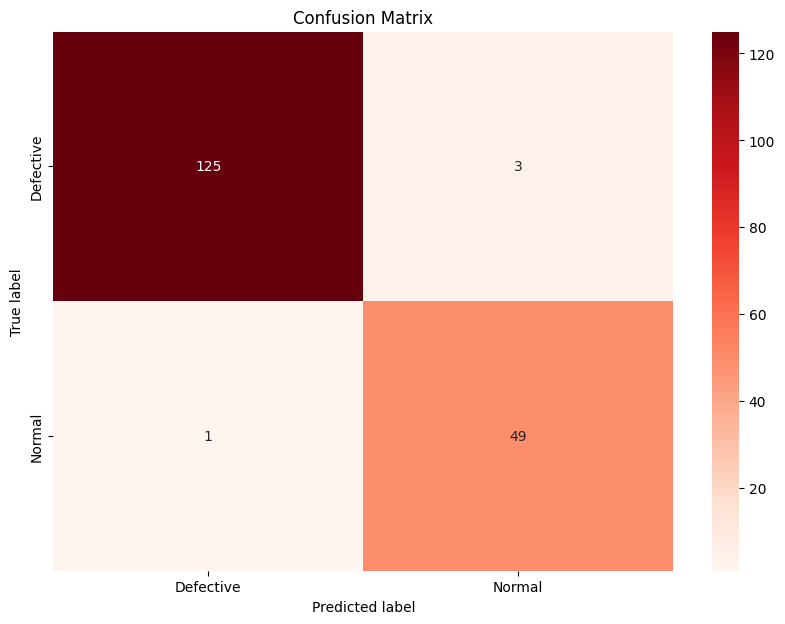

Accuracy 0.9775280898876404
Precision 0.9423076923076923
Recall (Sensitivity) 0.98
F1 Score 0.9607843137254902
mAP 0.9290795159896283


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtadammodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtadammodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

## **End ViT**

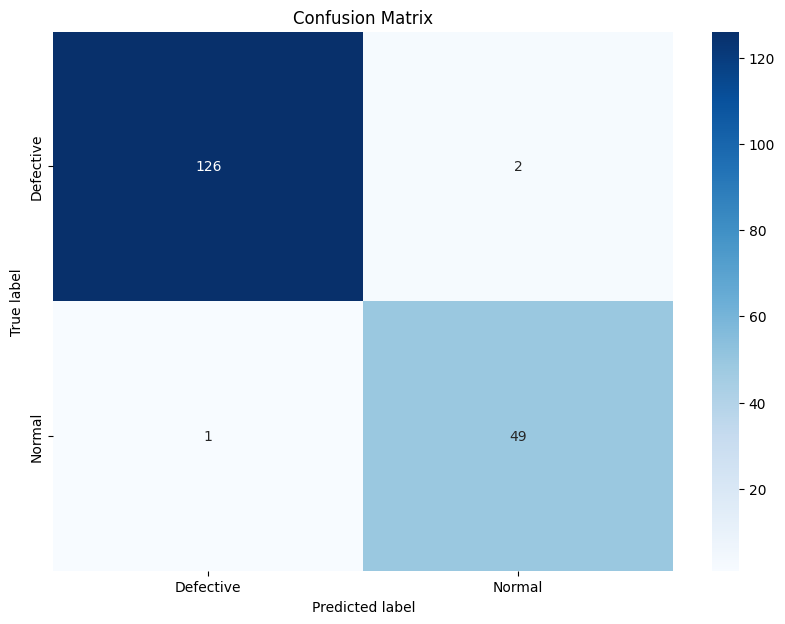

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


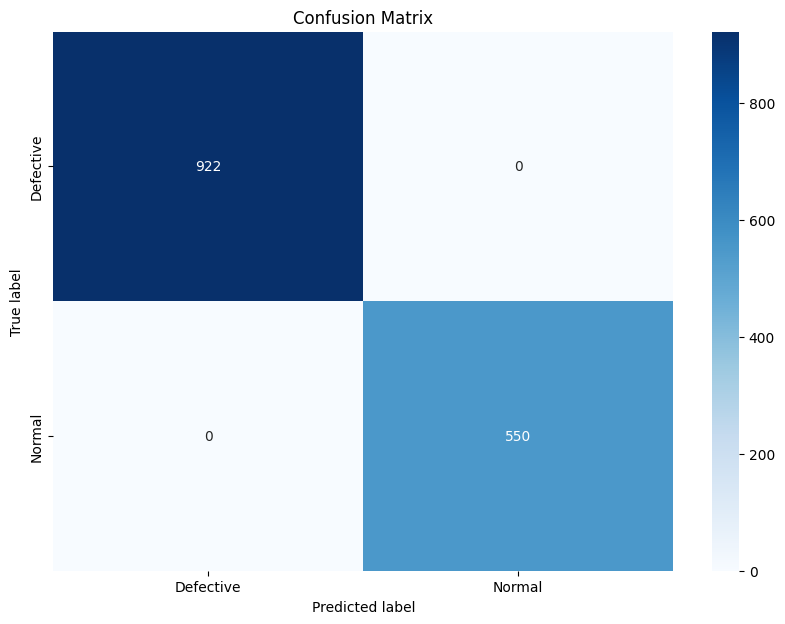

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")


Accuracy on the test dataset: 1.00


Accuracy on the test dataset: 1.00


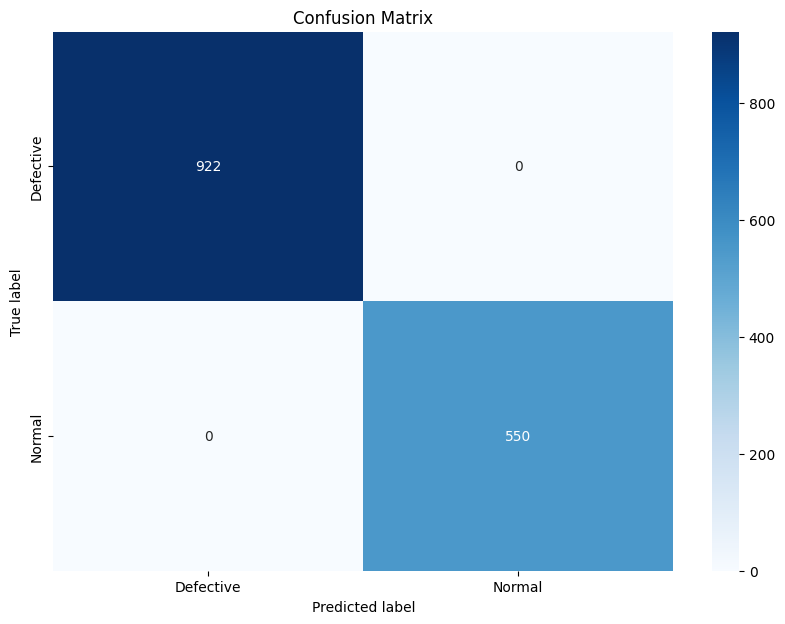

In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
vitinsul={'loss': [0.0941,0.0796,0.0268,0.0192,0.0115,0.0014,0.0009,0.0007,0.0006,0.0005],'accuracy': [0.9059,0.9204,0.9732,0.9808,0.9885,0.9986,0.9991,0.9993,0.9994,0.9995]}


In [ ]:
# Plot training loss
import os
import numpy as np
import matplotlib.pyplot as plt
vitinsul={'loss': [0.0941,0.0796,0.0268,0.0192,0.0115,0.0014,0.0009,0.0007,0.0006,0.0005],'accuracy': [0.9059,0.9204,0.9732,0.9808,0.9885,0.9986,0.9991,0.9993,0.9994,0.9995]}
epochs_range = range(10)
plt.figure(figsize=(8,8))
plt.plot(epochs_range, vitinsul['accuracy'], label='ViT Accuracy')
plt.title('Training Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [ ]:
epochs_range = range(10)
plt.figure(figsize=(8,8))
plt.plot(epochs_range, vitinsul['loss'], label='ViT Loss',color='red')
plt.title('Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc="upper left")
plt.grid()
plt.show()

# SWIM **Transformers**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

class SwinTransformerBlock(nn.Module):
    def __init__(self, in_channels, out_channels, window_size=7, shift_size=0, num_heads=4):
        super(SwinTransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(out_channels)
        self.norm2 = nn.LayerNorm(out_channels)
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, out_channels * 4),
            nn.ReLU(),
            nn.Linear(out_channels * 4, out_channels)
        )
        self.window_size = window_size
        self.shift_size = shift_size

    def forward(self, x):
        # Apply window-based multi-head self-attention
        x = self.norm1(x)
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output  # Skip connection

        # Feed-forward network
        x = self.norm2(x)
        x_ffn = self.ffn(x)
        x = x + x_ffn  # Skip connection

        return x

class SwinTransformer(nn.Module):
    def __init__(self, num_classes, embed_dim=96, num_layers=4, num_heads=4):
        super(SwinTransformer, self).__init__()
        self.embed_dim = embed_dim

        self.patch_size = 4  # Example patch size
        self.num_layers = num_layers

        # Initial linear projection for patch embedding
        self.proj = nn.Linear(3 * self.patch_size * self.patch_size, embed_dim)

        # Swin Transformer blocks
        self.layers = nn.ModuleList([
            SwinTransformerBlock(embed_dim, embed_dim, num_heads=num_heads) for _ in range(num_layers)
        ])

        # Classifier
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        batch_size, _, height, width = x.size()
        x = x.view(batch_size, 3, height // self.patch_size, self.patch_size, width // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5).reshape(batch_size, -1, 3 * self.patch_size * self.patch_size)
        x = self.proj(x)

        # Pass through Swin Transformer layers
        for layer in self.layers:
            x = layer(x)

        # Global average pooling
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

# Data preparation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

#train_dataset = ImageFolder(root='path_to_your_dataset/train', transform=transform)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_dataset = ImageFolder(os.path.join(PATH, 'Train'), transform=transform)
test_dataset = ImageFolder(os.path.join(PATH, 'Test'), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Hyperparameters
num_classes = len(train_dataset.classes)
#num_classes = 10  # Adjust based on your dataset
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Initialize model, loss, and optimizer
swimmodel = SwinTransformer(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swimmodel.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    swimmodel.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = swimmodel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Save the model
torch.save(swimmodel.state_dict(), 'swin_transformer_model.pth')


KeyboardInterrupt: 

In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load dataset
#dataset_dir = '/path/to/dataset'  # Update this path
train_dataset = ImageFolder(os.path.join(PATH, 'Train'), transform=transform)
test_dataset = ImageFolder(os.path.join(PATH, 'Test'), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
pip install torch torchvision transformers

In [ ]:
!pip install --upgrade transformers

In [ ]:
from transformers import AutoImageProcessor, SwinModel
import torch
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
swimmodel = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")



# Load a pretrained Swin model and feature extractor
#model_name = "microsoft/swin-base-patch4-window7-224"
#microsoft/swin-tiny-patch4-window7-224
#swimmodel = SwinForImageClassification.from_pretrained(model_name)
#feature_extractor = SwinFeatureExtractor.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swimmodel.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

SwinModel(
  (embeddings): SwinEmbeddings(
    (patch_embeddings): SwinPatchEmbeddings(
      (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    )
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): SwinEncoder(
    (layers): ModuleList(
      (0): SwinStage(
        (blocks): ModuleList(
          (0-1): 2 x SwinLayer(
            (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attention): SwinAttention(
              (self): SwinSelfAttention(
                (query): Linear(in_features=96, out_features=96, bias=True)
                (key): Linear(in_features=96, out_features=96, bias=True)
                (value): Linear(in_features=96, out_features=96, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): SwinSelfOutput(
                (dense): Linear(in_features=96, out_features=96, bias=True)
      

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vtmodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
vtmodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = vtmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(swimmodel.parameters(), lr=3e-4)

# Move the model to GPU if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#swimmodel.to(device)

# Training loop
num_epochs = 10
swimmodel.train()
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = swimmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # Store the average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


NameError: name 'train_loader' is not defined

In [ ]:
swimmodel.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = swimmodel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

vtmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vtmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(accuracy, color='silver', label='Accuracy')
plt.title('Training Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc="upper left")
plt.grid()
plt.show()

# **Adam Optimizer for DeiT (Data-efficient Image Transformers)**

In [ ]:
pip install torch torchvision transformers

In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations for training and testing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of Cait
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
#dataset_dir = '/path/to/dataset'  # Update this path
train_dataset = ImageFolder(os.path.join(PATH, 'Train'), transform=transform_train)
test_dataset = ImageFolder(os.path.join(PATH, 'Test'), transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
from transformers import DeiTForImageClassification, DeiTFeatureExtractor

# Load a pretrained DeiT model and feature extractor
model_name = "facebook/deit-base-distilled-patch16-224"
deitmodel = DeiTForImageClassification.from_pretrained(model_name)
feature_extractor = DeiTFeatureExtractor.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deitmodel.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): L

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(deitmodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
deitmodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = deitmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 49/49 [03:48<00:00,  4.67s/it]


Epoch [1/10], Loss: 0.0325


100%|██████████| 49/49 [03:41<00:00,  4.52s/it]


Epoch [2/10], Loss: 0.0319


100%|██████████| 49/49 [03:36<00:00,  4.41s/it]


Epoch [3/10], Loss: 0.0064


100%|██████████| 49/49 [03:39<00:00,  4.48s/it]


Epoch [4/10], Loss: 0.0119


100%|██████████| 49/49 [03:39<00:00,  4.48s/it]


Epoch [5/10], Loss: 0.0201


100%|██████████| 49/49 [03:37<00:00,  4.44s/it]


Epoch [6/10], Loss: 0.0025


100%|██████████| 49/49 [04:34<00:00,  5.60s/it]


Epoch [7/10], Loss: 0.0000


100%|██████████| 49/49 [04:38<00:00,  5.67s/it]


Epoch [8/10], Loss: 0.0000


100%|██████████| 49/49 [03:41<00:00,  4.52s/it]


Epoch [9/10], Loss: 0.0000


100%|██████████| 49/49 [03:38<00:00,  4.46s/it]

Epoch [10/10], Loss: 0.0000


Accuracy on the test dataset: 1.00


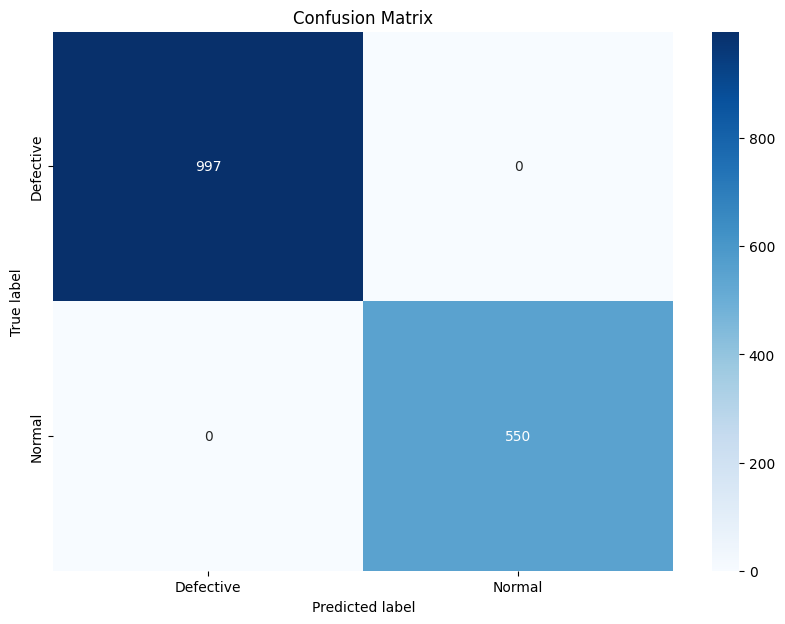

In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

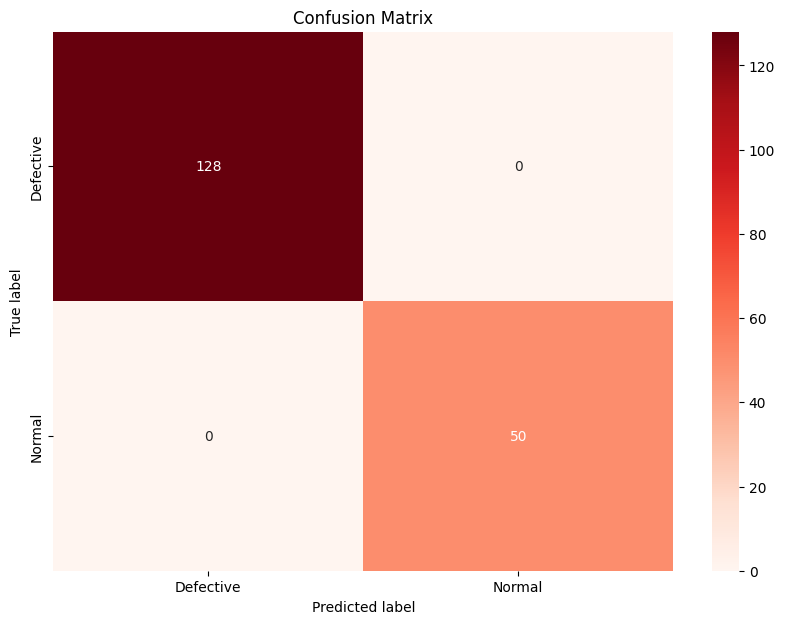

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

CrossViT: Cross-Attention Multi-Scale Vision Transformer for Image Classification

In [ ]:
deitinsul={'loss': [0.0325,0.0319, 0.0064,0.0119,0.0201,0.0025,0.0000,0.0000,0.0000,0.0000],'accuracy': [1-0.0325,1-0.0319, 1-0.0064,1-0.0119,1-0.0201,1-0.0025,1-0.0000,1-0.0000,1-0.0000,1-0.0000]}

Epoch [1/10], Loss: 0.0325
100%|██████████| 49/49 [03:41<00:00,  4.52s/it]
Epoch [2/10], Loss: 0.0319
100%|██████████| 49/49 [03:36<00:00,  4.41s/it]
Epoch [3/10], Loss: 0.0064
100%|██████████| 49/49 [03:39<00:00,  4.48s/it]
Epoch [4/10], Loss: 0.0119
100%|██████████| 49/49 [03:39<00:00,  4.48s/it]
Epoch [5/10], Loss: 0.0201
100%|██████████| 49/49 [03:37<00:00,  4.44s/it]
Epoch [6/10], Loss: 0.0025
100%|██████████| 49/49 [04:34<00:00,  5.60s/it]
Epoch [7/10], Loss: 0.0000
100%|██████████| 49/49 [04:38<00:00,  5.67s/it]
Epoch [8/10], Loss: 0.0000
100%|██████████| 49/49 [03:41<00:00,  4.52s/it]
Epoch [9/10], Loss: 0.0000
100%|██████████| 49/49 [03:38<00:00,  4.46s/it]Epoch [10/10], Loss: 0.0000

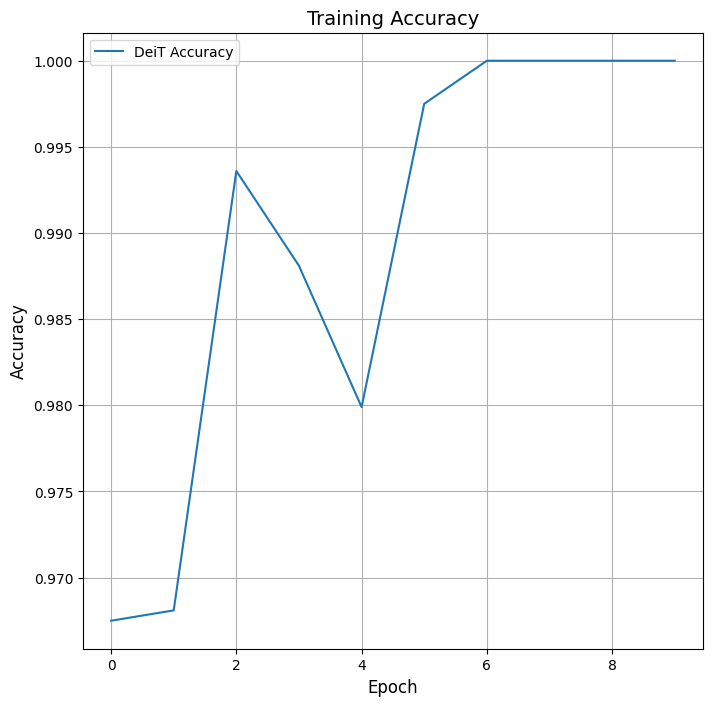

In [ ]:
# Plot training loss
import os
import numpy as np
import matplotlib.pyplot as plt
epochs_range = range(10)
plt.figure(figsize=(8,8))
plt.plot(epochs_range, deitinsul['accuracy'], label='DeiT Accuracy')
plt.title('Training Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc="upper left")
plt.grid()
plt.show()

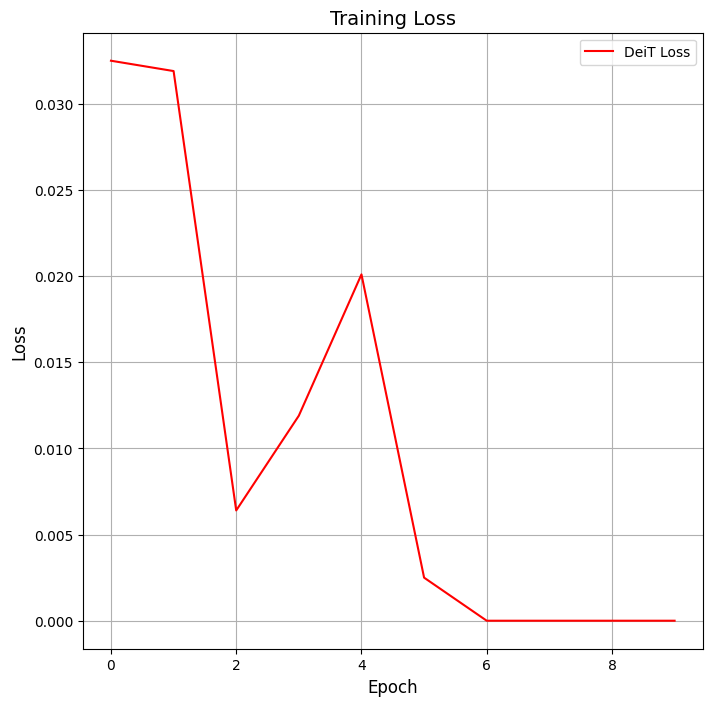

In [ ]:
epochs_range = range(10)
plt.figure(figsize=(8,8))
plt.plot(epochs_range, deitinsul['loss'], label='DeiT Loss',color='red')
plt.title('Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc="upper right")
plt.grid()
plt.show()

# **Adadelta for Deit**

In [ ]:
from transformers import DeiTForImageClassification, DeiTFeatureExtractor

# Load a pretrained DeiT model and feature extractor
model_name = "facebook/deit-base-distilled-patch16-224"
deitadadeltamodel = DeiTForImageClassification.from_pretrained(model_name)
feature_extractor = DeiTFeatureExtractor.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deitadadeltamodel.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): L

In [ ]:
import torch.nn as nn
from torch.optim import Adadelta
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adadelta(deitadadeltamodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
deitadadeltamodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = deitadadeltamodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 41/41 [51:37<00:00, 75.54s/it]


Epoch [1/10], Loss: 6.6747


100%|██████████| 41/41 [46:27<00:00, 67.99s/it]


Epoch [2/10], Loss: 6.2733


100%|██████████| 41/41 [46:33<00:00, 68.13s/it]


Epoch [3/10], Loss: 5.8162


100%|██████████| 41/41 [46:31<00:00, 68.09s/it]


Epoch [4/10], Loss: 5.2759


100%|██████████| 41/41 [46:24<00:00, 67.91s/it]


Epoch [5/10], Loss: 4.6448


100%|██████████| 41/41 [46:27<00:00, 68.00s/it]


Epoch [6/10], Loss: 3.9217


 39%|███▉      | 16/41 [18:13<28:22, 68.10s/it]

In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitadadeltamodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitadadeltamodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitadadeltamodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitadadeltamodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

# **SGD for DeiT**

In [ ]:
from transformers import DeiTForImageClassification, DeiTFeatureExtractor

# Load a pretrained DeiT model and feature extractor
model_name = "facebook/deit-base-distilled-patch16-224"
deitmodel = DeiTForImageClassification.from_pretrained(model_name)
feature_extractor = DeiTFeatureExtractor.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deitmodel.to(device)

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(deitmodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
deitmodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = deitmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
# Calculate metrics
def calculate_metrics(cm):
    # True Positives, False Positives, False Negatives, True Negatives
    TP = np.diag(conf_matrix)  # True positives are on the diagonal
    FP = np.sum(conf_matrix, axis=0) - TP  # False positives
    FN = np.sum(conf_matrix, axis=1) - TP  # False negatives
    TN = np.sum(conf_matrix) - (FP + FN + TP)  # True negatives

    # Precision, Recall, Specificity
    precision = TP / (TP + FP + 1e-10)  # Avoid division by zero
    recall = TP / (TP + FN + 1e-10)
    specificity = TN / (TN + FP + 1e-10)

    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    # Overall Accuracy
    accuracy = np.sum(TP) / np.sum(cm)

    # Fowlkes-Mallows Index (FM)
    FM = np.sqrt(precision * recall)

    return precision, recall, accuracy, f1, specificity, FM

# Calculate metrics
precision, recall, accuracy, f1, specificity, FM = calculate_metrics(cm)

# Print results
print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("Overall Accuracy:", accuracy)
print("F1 Score for each class:", f1)
print("Specificity for each class:", specificity)
print("Fowlkes-Mallows Index for each class:", FM)

AdaGrad for Deit

In [ ]:
from transformers import DeiTForImageClassification, DeiTFeatureExtractor

# Load a pretrained DeiT model and feature extractor
model_name = "facebook/deit-base-distilled-patch16-224"
deitmodel = DeiTForImageClassification.from_pretrained(model_name)
feature_extractor = DeiTFeatureExtractor.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deitmodel.to(device)

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(deitmodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
deitmodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = deitmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")



In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

RMSprop for DeiT

In [ ]:
from transformers import DeiTForImageClassification, DeiTFeatureExtractor

# Load a pretrained DeiT model and feature extractor
model_name = "facebook/deit-base-distilled-patch16-224"
deitmodel = DeiTForImageClassification.from_pretrained(model_name)
feature_extractor = DeiTFeatureExtractor.from_pretrained(model_name)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deitmodel.to(device)

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(deitmodel.parameters(), lr=3e-4)

# Training loop
num_epochs = 10
deitmodel.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = deitmodel(images).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

deitmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
# Calculate Accuracy
acc = accuracy_score(all_labels, all_predictions)

# Calculate Precision
precision = precision_score(all_labels, all_predictions, average='binary')

# Calculate Recall (Sensitivity)
recall = recall_score(all_labels, all_predictions, average='binary')

# Calculate F1 Score
f1 = f1_score(all_labels, all_predictions, average='binary')

# If it's binary classification, we can also calculate mAP by using average_precision_score
mAP = average_precision_score(all_labels, all_predictions) if len(np.unique(all_labels)) > 1 else None
# Return calculated metrics
print("Accuracy", acc)
print("Precision", precision)
print("Recall (Sensitivity)", recall)
print("F1 Score", f1)
print("mAP",mAP)

# Cross-**ViT**

In [ ]:
pip install tensorflow tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Define the CrossViT model (simplified version)
class CrossViT(layers.Layer):
    def __init__(self, num_classes):
        super(CrossViT, self).__init__()
        # Add your CrossViT layers here
        # This is a simplified version
        self.base_model = keras.applications.ViT(
            include_top=False,
            weights='imagenet',
            pooling='avg'
        )
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.base_model(inputs)
        return self.classifier(x)

# Load and preprocess your dataset

#dataset_dir = '/path/to/dataset'  # Update this path
train_dataset = ImageFolder(os.path.join(PATH, 'Train'), transform=transform_train)
test_dataset = ImageFolder(os.path.join(PATH, 'Test'), transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
def load_data(image_dir, img_size, batch_size):
    datagen = keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255
    )

    train_generator = datagen.flow_from_directory(
        image_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    test_generator = datagen.flow_from_directory(
        image_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

# Parameters
image_directory = os.path.join(PATH, 'Train')
image_size = 224  # Size of input images
batch_size = 32
num_classes = len(tf.keras.utils.list_dir(image_directory))  # Adjust based on your dataset

# Load data
train_data, test_data = load_data(image_directory, image_size, batch_size)

# Build and compile the model
model = CrossViT(num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
model.fit(
    train_data,
    validation_data=val_data,
    epochs=10  # Adjust the number of epochs
)

# Save the model
model.save('crossvit_model.h5')


In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations for training and testing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of Cait
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
#dataset_dir = '/path/to/dataset'  # Update this path
train_dataset = ImageFolder(os.path.join(PATH, 'Train'), transform=transform_train)
test_dataset = ImageFolder(os.path.join(PATH, 'Test'), transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

class CrossViT(nn.Module):
    def __init__(self, num_classes):
        super(CrossViT, self).__init__()
        # Example components; replace with your actual CrossViT architecture
        self.patch_size = 16
        self.embed_dim = 768
        self.num_heads = 12
        self.num_layers = 12

        # Vision Transformer layers
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=self.num_heads)
        self.classifier = nn.Linear(self.embed_dim, num_classes)

    def forward(self, x):
        # Tokenization and embedding steps
        batch_size, _, height, width = x.size()
        x = x.view(batch_size, 3, height // self.patch_size, self.patch_size, width // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5).reshape(batch_size, -1, 3 * self.patch_size * self.patch_size)

        # Pass through transformer
        x = self.transformer_layer(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.classifier(x)
        return x

# Hyperparameters
num_classes = 2  # Adjust based on your dataset
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data preparation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
# Define transformations for training and testing
transform_train = transforms.Compose([
    transforms.Resize((128,128)),  # Resize to the input size of Cait
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load datasets
#dataset_dir = '/path/to/dataset'  # Update this path
train_dataset = ImageFolder(os.path.join(PATH, 'Train'), transform=transform_train)
test_dataset = ImageFolder(os.path.join(PATH, 'Test'), transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#train_dataset = ImageFolder(root='path_to_your_dataset/train', transform=transform)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer


cvitmodel = CrossViT(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cvitmodel.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    cvitmodel.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = cvitmodel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

     # Testing
    cvitmodel.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = cvitmodel(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')


# Save the model
torch.save(cvitmodel.state_dict(), 'crossvit_model.pth')


Epoch [1/10], Loss: 1.0849
Epoch [1/10], Test Loss: 3.9477, Accuracy: 21.3333
Epoch [2/10], Loss: 0.6587
Epoch [2/10], Test Loss: 3.8524, Accuracy: 21.3333
Epoch [3/10], Loss: 0.6675
Epoch [3/10], Test Loss: 3.8189, Accuracy: 21.3333
Epoch [4/10], Loss: 0.6541
Epoch [4/10], Test Loss: 3.8189, Accuracy: 21.3333
Epoch [5/10], Loss: 0.6621
Epoch [5/10], Test Loss: 3.8845, Accuracy: 21.3333
Epoch [6/10], Loss: 0.6657
Epoch [6/10], Test Loss: 3.9705, Accuracy: 21.3333
Epoch [7/10], Loss: 0.6700
Epoch [7/10], Test Loss: 3.9629, Accuracy: 21.3333
Epoch [8/10], Loss: 0.6628
Epoch [8/10], Test Loss: 3.8683, Accuracy: 21.3333
Epoch [9/10], Loss: 0.6560
Epoch [9/10], Test Loss: 3.8653, Accuracy: 21.3333
Epoch [10/10], Loss: 0.6695
Epoch [10/10], Test Loss: 3.9537, Accuracy: 21.3333


In [ ]:
import torch
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []
cvitmodel.eval()

with torch.no_grad():
    for images, labels in train_loader:
#       images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy on the test dataset: {accuracy:.2f}")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'deitmodel' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

cvitmodel.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = deitmodel(images).logits
        _, predicted = torch.max(outputs.data, 1)

        # Collect true labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Epoch [1/10], Loss: 0.8311
Epoch [2/10], Loss: 0.6802
Epoch [3/10], Loss: 0.6613
Epoch [4/10], Loss: 0.6801
Epoch [5/10], Loss: 0.6725
Epoch [6/10], Loss: 0.6547
Epoch [7/10], Loss: 0.6381
Epoch [8/10], Loss: 0.6477

In [ ]:
cvitinsul={'loss': [0.0325,0.0319, 0.0064,0.0119,0.0201,0.0025,0.0000,0.0000,0.0000,0.0000],'accuracy': [1-0.0325,1-0.0319, 1-0.0064,1-0.0119,1-0.0201,1-0.0025,1-0.0000,1-0.0000,1-0.0000,1-0.0000]}

In [ ]:
# Plot training loss
import os
import numpy as np
import matplotlib.pyplot as plt
epochs_range = range(10)
plt.figure(figsize=(8,8))
plt.plot(epochs_range, deitinsul['accuracy'], label='DeiT Accuracy')
plt.title('Training Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc="upper left")
plt.grid()
plt.show()

In [ ]:
epochs_range = range(10)
plt.figure(figsize=(8,8))
plt.plot(epochs_range, deitinsul['loss'], label='DeiT Loss',color='red')
plt.title('Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc="upper right")
plt.grid()
plt.show()